# 'Automatic Deep Learning Model for Speech to Plant's Diseased-Image Generation.'

In this project we are using various multimedia sources such as audio, text and pictures in order to perform the required task. It consist of 3 modules which works together in order complete our required work.
>First module is audio to text conversion

>Second moudle is text to healthy leaf image generation

>Third is healthy leaf image to diseased leaf image generation

# Audio to text code

In [1]:
! pip install -q transformers

In [2]:
TF_ENABLE_ONEDNN_OPTS=0
import librosa
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer


2022-12-01 07:02:18.075034: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
#load pre-trained model and tokenizer
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/home/tauqeer/anaconda3/envs/tf/lib/python3.9/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:752: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
speech1,rate1=librosa.load("InputAudio/1.mp3",sr=15000)
speech2,rate2=librosa.load("InputAudio/2.mp3",sr=12000)

In [5]:
import IPython.display as display
display.Audio("InputAudio/1.mp3", autoplay=True)


In [6]:
display.Audio("InputAudio/2.mp3", autoplay=True)

In [7]:
input_values1 = tokenizer(speech1, return_tensors = 'pt').input_values
input_values2 = tokenizer(speech2, return_tensors = 'pt').input_values

In [8]:
# Store logits (non-normalized predictions)

logits1=model(input_values1).logits
logits2=model(input_values2).logits

In [9]:
#Store predicted id's
predicted_ids1 = torch.argmax(logits1, dim =-1)
predicted_ids2 = torch.argmax(logits2, dim =-1)

In [10]:
#decode the audio to generate text
transcriptions1= tokenizer.decode(predicted_ids1[0])
transcriptions2= tokenizer.decode(predicted_ids2[0])

In [11]:
text=transcriptions1
print(transcriptions1)
text2=transcriptions2
print(transcriptions2)

LEAF OF APPLE
LEAF OF TAMATO


# Text to image

In [12]:
! pip install min-dalle -q

In [ ]:
from min_dalle import MinDalle
from PIL import Image
model = MinDalle(is_mega=True, is_reusable=True)

In [ ]:
seed = 6  
grid_size = 1
img_save1=model.generate_image(text, seed, grid_size)
img_save2=model.generate_image(text2, seed, grid_size)

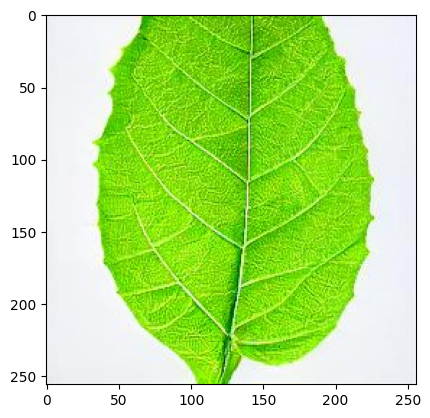

In [ ]:
img_save1=img_save1.save("OutputImages/"+text+".jpg")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("OutputImages/"+text+".jpg")
imgplot = plt.imshow(img)
plt.show()

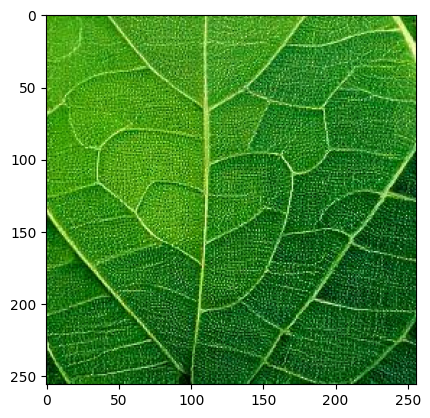

In [ ]:
img_save2=img_save2.save("OutputImages/"+text2+".jpg")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img2 = mpimg.imread("OutputImages/"+text2+".jpg")
imgplot = plt.imshow(img2)
plt.show()

# Healthy image to diseased image

In [ ]:
!pip3 install -q git+https://github.com/tensorflow/examples.git

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython import display

from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
import efficientnet.tfkeras as efn
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

from tqdm import tqdm as tqdm
import gc
# Data access
# from kaggle_datasets import KaggleDatasets
# GCS_DS_PATH = KaggleDatasets().get_gcs_path()

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
def InitializeSession():
    tf.compat.v1.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    tf.compat.v1.set_random_seed(123)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
InitializeSession()
EPOCHS = 600
SAMPLE_LEN = 100
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

IMAGE_PATH = 'plant-pathology-2020-fgvc7/images'
TEST_PATH = 'plant-pathology-2020-fgvc7/test.csv'
TRAIN_PATH = 'plant-pathology-2020-fgvc7/train.csv'
SUB_PATH = 'plant-pathology-2020-fgvc7/sample_submission.csv'

sub = pd.read_csv(SUB_PATH)
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)
md_gan = []

2022-12-01 04:24:01.522132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 04:24:05.687160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2435 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-12-01 04:24:05.688324: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13337 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:af:00.0, compute capability: 7.5
2022-12-01 04:24:05.689194: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:

In [ ]:
def format_path(st):
    return 'plant-pathology-2020-fgvc7' + '/images/' + st + '.jpg'

In [ ]:
train_data.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [ ]:
healthy = train_data[train_data['healthy']>0]
multiple_diseases = train_data[train_data['multiple_diseases']>0]
rust = train_data[train_data['rust']>0]
scab = train_data[train_data['scab']>0]

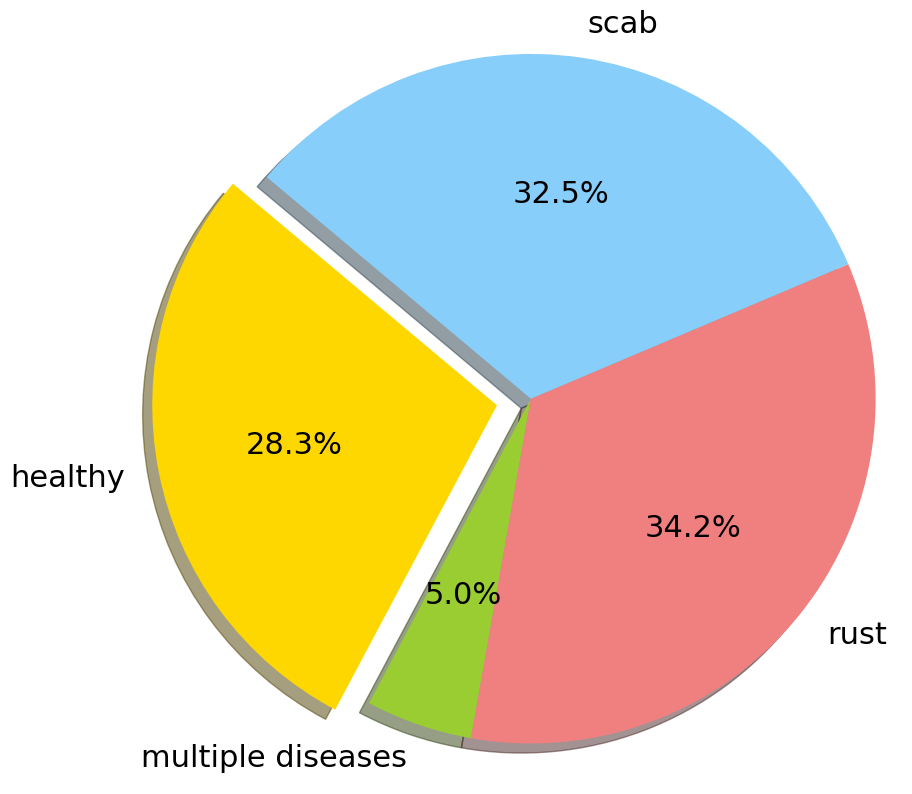

In [ ]:
labels = 'healthy', 'multiple diseases', 'rust', 'scab'
sizes = [len(healthy), len(multiple_diseases), len(rust), len(scab)]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice

# Plot
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [ ]:
def load_image(image_id, label=None, image_size=(IMG_WIDTH, IMG_HEIGHT)):
    if image_id.numpy().decode("utf-8").split('_')[0]=='gan' and len(image_id.numpy().decode("utf-8").split('_'))==2:
        image_id = int(image_id.numpy().decode("utf-8").split('_')[1])
        return md_gan[image_id], [0,1,0,0]
    else:        
        bits = tf.io.read_file(image_id)
        image = tf.image.decode_jpeg(bits, channels=3)
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, image_size)
        if label is None:
            return image
        else:
            return image, label

In [ ]:
def decode_image(filename, label=None, image_size=(512, 512)):
    image_size=(256,256)
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    if label is None:
        return image
    else:
        return image, label

In [ ]:
def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if label is None:
        return image
    else:
        return image, label

In [ ]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [ ]:
def random_jitter(image):
    # resizing to 256 x 256 x 3
    image = tf.image.resize(image, [256,256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

In [ ]:
def preprocess_image_train(image, label):
    bits = tf.io.read_file(image)
    image = tf.image.decode_jpeg(bits, channels=3)
    
    image = random_jitter(image)
    image = normalize(image)
    return image

In [ ]:
def preprocess_image_test(image, label):
    image = normalize(image)
    return image

In [ ]:
healthy_imgs = healthy.image_id.apply(format_path).values
md_imgs = multiple_diseases.image_id.apply(format_path).values

In [ ]:
train_healthy = (
    tf.data.Dataset
    .from_tensor_slices((healthy_imgs, ['healthy_train']*len(healthy_imgs)))
    .map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(1)
)
train_md = (
    tf.data.Dataset
    .from_tensor_slices((md_imgs, ['multiple_diseases_train']*len(md_imgs)))
    .map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(1)
)

2022-12-01 04:24:09.505138: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2435 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-12-01 04:24:09.505803: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13337 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:af:00.0, compute capability: 7.5
2022-12-01 04:24:09.506410: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13337 MB memory:  -> device: 2, name: Tesla T4, pci bus id: 0000:d8:00.0, compute capability: 7.5


In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
sample_healthy = next(iter(train_healthy))
sample_md = next(iter(train_md))

2022-12-01 04:24:17.180186: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-12-01 04:24:17.711686: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-01 04:24:17.711745: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-01 04:24:17.718718: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

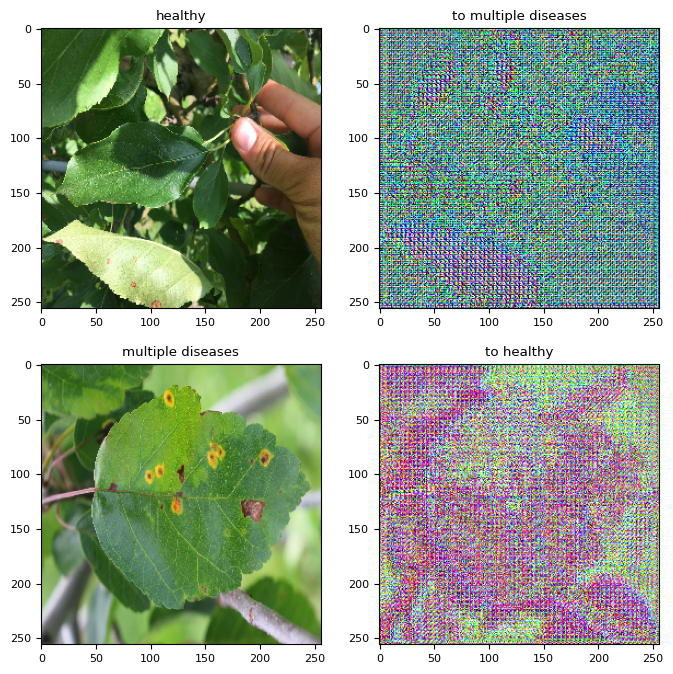

In [ ]:
to_md = generator_g(sample_healthy)
to_healthy = generator_f(sample_md)
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(8, 8))
contrast = 8
imgs = [sample_healthy, to_md, sample_md, to_healthy]
title = ['healthy', 'to multiple diseases', 'multiple diseases', 'to healthy']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

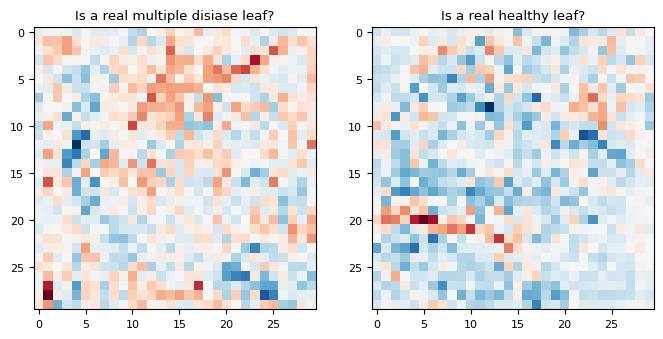

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real multiple disiase leaf?')
plt.imshow(discriminator_y(sample_md)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real healthy leaf?')
plt.imshow(discriminator_x(sample_healthy)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [ ]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image-cycled_image))
    return LAMBDA * 0.5 * loss1

In [ ]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./checkpoints"

ckpt = tf.train.Checkpoint(
    generator_g = generator_g,
    generator_f = generator_f,
    discriminator_x = discriminator_x,
    discriminator_y = discriminator_y,
    generator_g_optimizer = generator_g_optimizer,
    generator_f_optimizer = generator_f_optimizer,
    discriminator_x_optimizer=discriminator_x_optimizer,
    discriminator_y_optimizer=discriminator_y_optimizer
)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
def generate_images(model, test_input):
    prediction = model(test_input)
    
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


In [ ]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                          generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                          generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                          discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

Last epoch presnt in the saved checkpoint

In [ ]:
ckpt.save_counter.numpy()

600

In [ ]:

for epoch in range(ckpt.save_counter.numpy(), EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_healthy, train_md)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
        n+=1

    clear_output(wait=True)
    # Using a consistent image (sample_horse) so that the progress of the model
    # is clearly visible.
    generate_images(generator_g, sample_healthy)
    ckpt_save_path = ckpt_manager.save()
    
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                              time.time()-start))

#     print ('Saving checkpoint for epoch {} at {}'.format(epoch+1))

In [ ]:
disp_img=[]
temp=0
for image_ in tf.data.Dataset.zip(train_healthy):
    temp=image_
    disp_img.append(image_)
    prediction_ = generator_g(image_)
    md_gan.append(prediction_[0].numpy() * 0.5 + 0.5)

# Prediction

Results on test data set

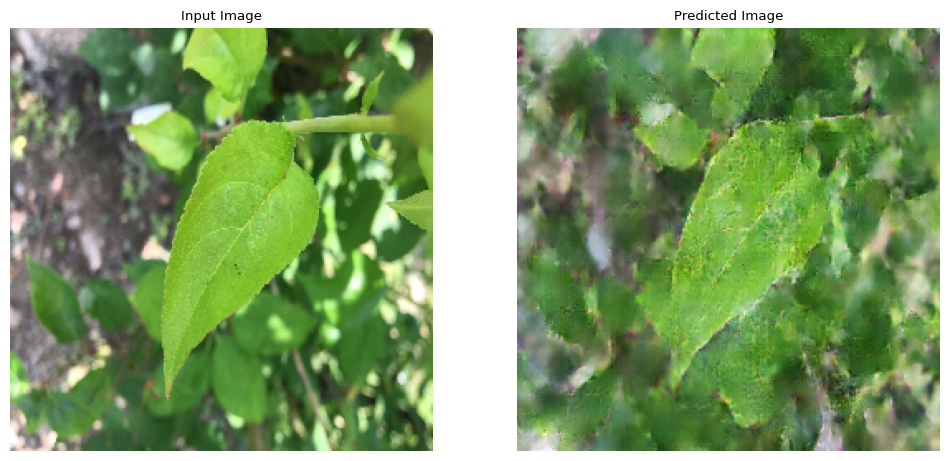

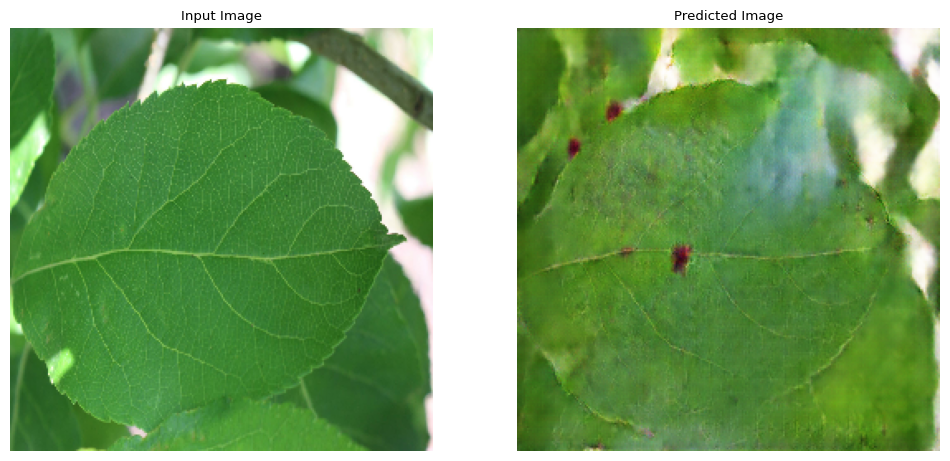

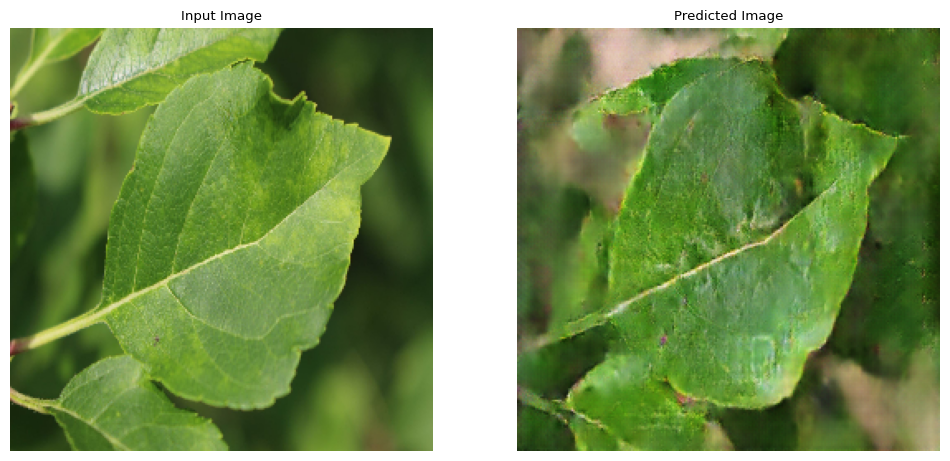

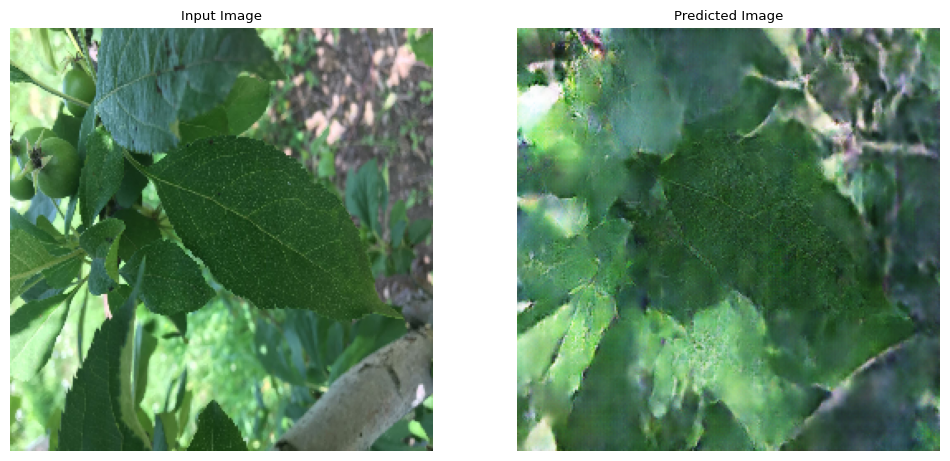

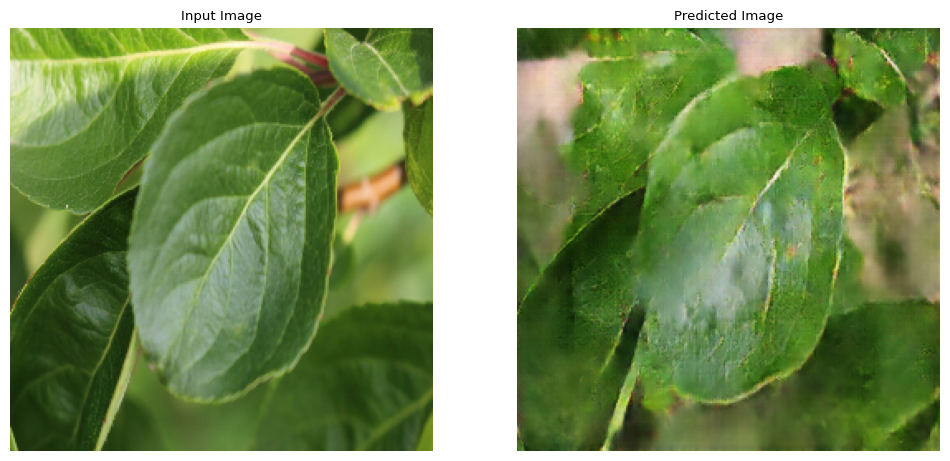

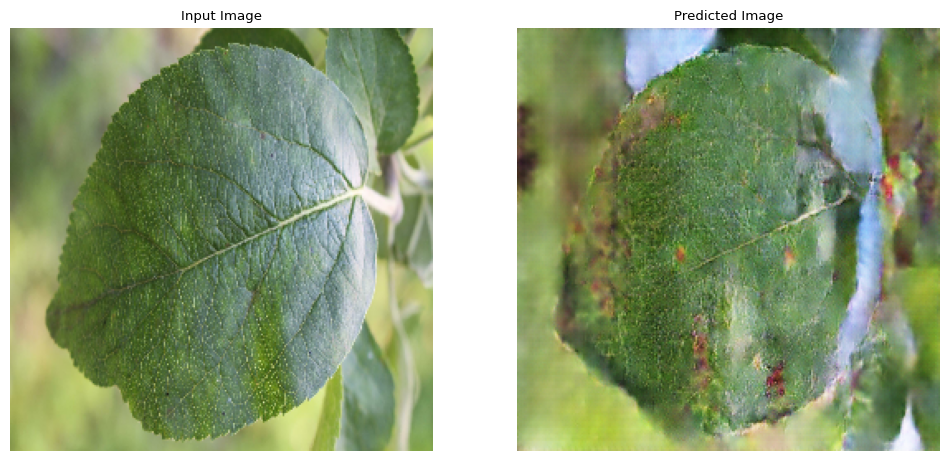

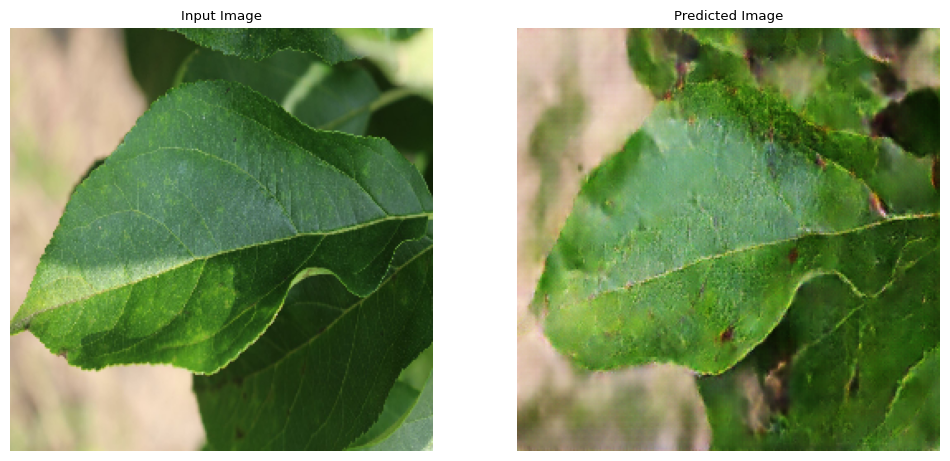

In [ ]:
for i in range(7):
    generate_images(generator_g, disp_img[i])

# Test on the generated leaf image

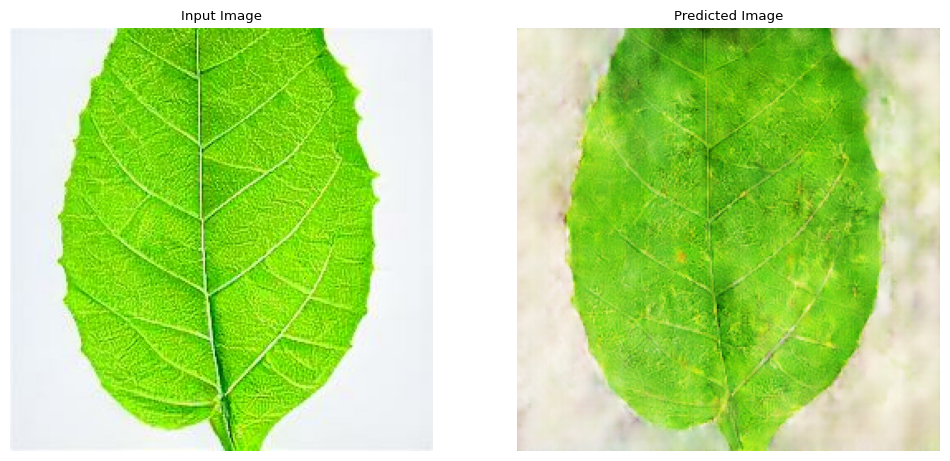

In [ ]:
imag=preprocess_image_train('OutputImages/LEAF OF APPLE.jpg',1)
imag=tf.reshape(imag,[1,256,256,3])
imag.shape
generate_images(generator_g,imag)

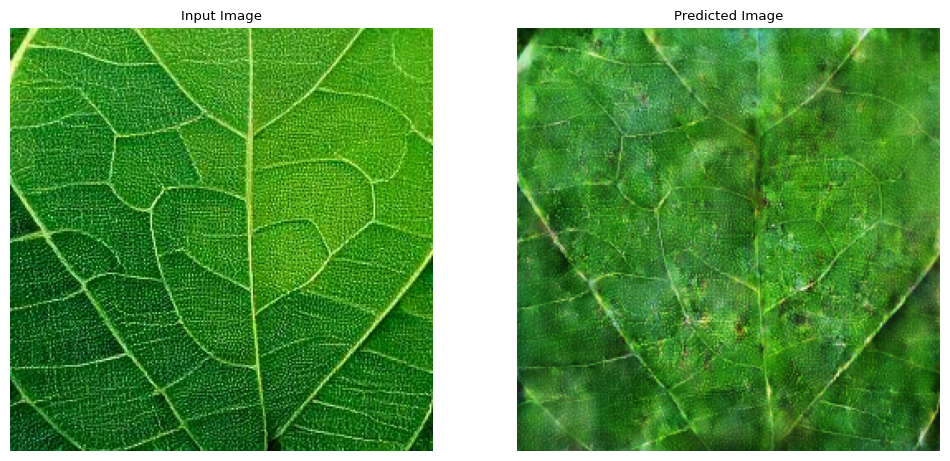

In [ ]:
imag=preprocess_image_train('OutputImages/LEAF OF TAMATO.jpg',1)
imag=tf.reshape(imag,[1,256,256,3])
imag.shape
generate_images(generator_g,imag)